In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# from IPython.display import clear_output

# import warnings
# warnings.filterwarnings('ignore')

In [6]:
train_dir = 'Dataset_Orange/Train'
test_dir = 'Dataset_Orange/Single_Pred'
val_dir = 'Dataset_Orange/Test'

In [7]:
data_train = image_dataset_from_directory(train_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_validation = image_dataset_from_directory(val_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_test = image_dataset_from_directory(test_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)

Found 3058 files belonging to 2 classes.
Found 791 files belonging to 2 classes.
Found 4 files belonging to 2 classes.


In [8]:
IMG_SIZE = (256, 256)

# data argumentation
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                       rotation_range=45,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True
                                       )

# data argumentation
test_datagen = ImageDataGenerator(rescale= 1 / 255.0)

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=200, 
                                         shuffle=True,
                                         class_mode="categorical")
test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="categorical")

Found 3058 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 791 images belonging to 2 classes.


In [9]:
# using mobilenetv2 model
mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(256,256,3))
# make pre trained model into non trainable bcoz its takes much time
for layer in mobilenet.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 3s 0us/step


In [10]:
# Initialize the model in sequential
model = Sequential()
# add MobileNetV2 model into our sequence model
model.add(mobilenet)
# flatten the model
model.add(Flatten())
# Adding dense layers
model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
# Adding output layer
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10485888  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 12,744,130
Trainable params: 10,486,146
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# model compile
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [12]:
history = model.fit(train_dataset,
                              validation_data=validation_dataset,
                              epochs=3,
                              verbose=1)

Epoch 1/3
16/16 [==============================] - 440s 27s/step - loss: 0.5928 - accuracy: 0.7315 - val_loss: 0.4624 - val_accuracy: 0.8786
Epoch 2/3
16/16 [==============================] - 308s 19s/step - loss: 0.4352 - accuracy: 0.9199 - val_loss: 0.4292 - val_accuracy: 0.9178
Epoch 3/3
16/16 [==============================] - 307s 19s/step - loss: 0.4264 - accuracy: 0.9251 - val_loss: 0.4241 - val_accuracy: 0.9090


In [13]:
model.evaluate(validation_dataset)

13/13 [==============================] - 54s 4s/step - loss: 0.4237 - accuracy: 0.9090


[0.42365771532058716, 0.9089759588241577]

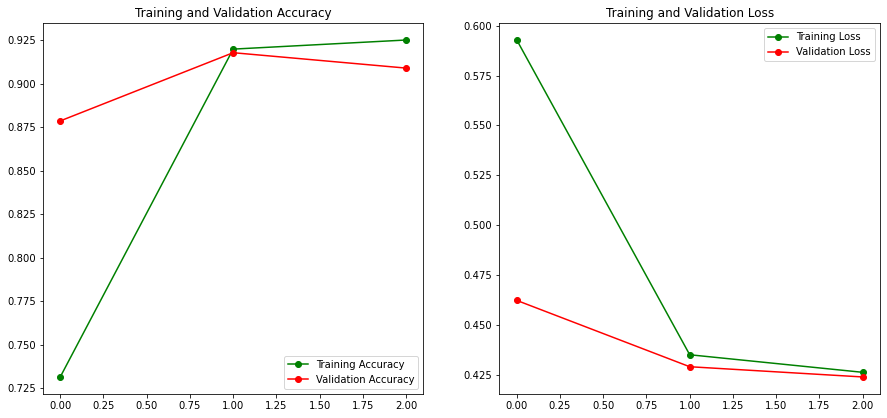

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc,"go-", label='Training Accuracy')
plt.plot(epochs_range, val_acc,"ro-", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss,"go-", label='Training Loss')
plt.plot(epochs_range, val_loss,"ro-", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
test_pred = model.predict(validation_dataset)

In [16]:
output = [np.argmax(op) for op in test_pred]
df_output = pd.DataFrame(output)
print(df_output.value_counts())

0    451
1    340
dtype: int64


In [23]:
def img_preprocessing(path):
    sample_mask_img = cv2.imread(path)
    sample_mask_img = cv2.resize(sample_mask_img,(256,256))
    plt.imshow(sample_mask_img)
    sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    print(res)

1


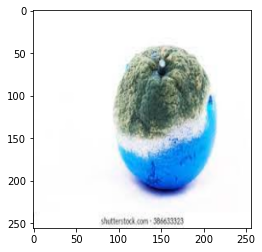

In [30]:
img_preprocessing('Dataset_Orange/Single_Pred/rottenoranges/rotten2.jpg')